In [1]:
import sys
!{sys.executable} -m pip install pandas requests seaborn matplotlib scikit-learn imbalanced-learn

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

In [3]:
arquivo_csv = "TelecomX_Dados_Tratados.csv"
dataclean = pd.read_csv(arquivo_csv)

In [4]:
dataclean = dataclean.drop(columns=['customerID'])

In [5]:
boolean_cols = ['Idoso', 'Parceiro', 'Dependentes', 'Servico_Celular', 
                'Linhas_Adicionais', 'Servico_Internet', 'Seguranca_Online', 
                'Backup_Online', 'Protecao_Dispositivo', 'Suporte_Tecnico', 
                'TV_Streaming', 'Filmes_Streaming', 'Faturamento_Sem_Papel']
for col in boolean_cols:
    dataclean[col] = dataclean[col].map({'Sim': 1, 'Nao': 0})

In [6]:
categorical_cols = ['Genero', 'Contrato', 'Metodo_de_Pagamento']
dataclean = pd.get_dummies(dataclean, columns=categorical_cols, drop_first=True)

In [7]:
num_cols = ['Meses_Cliente', 'Faturamento_Mensal', 'Faturamento_Total', 'Contas_Diarias']
for col in num_cols:
    dataclean[col] = pd.to_numeric(dataclean[col], errors='coerce')

In [8]:
imputer_num = SimpleImputer(strategy='median')
dataclean[num_cols] = imputer_num.fit_transform(dataclean[num_cols])

In [9]:
dataclean[boolean_cols] = dataclean[boolean_cols].fillna(0)
dataclean = dataclean.fillna(0)

In [10]:
dataclean['Churn_Num'] = dataclean['Churn'].map({'Não': 0, 'Sim': 1})

In [11]:
X = dataclean.drop(['Churn', 'Churn_Num'], axis=1)
y = dataclean['Churn_Num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [12]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Regressão Logística
log_model = LogisticRegression(random_state=42)
log_model.fit(X_train_scaled, y_train_bal)
y_pred_log = log_model.predict(X_test_scaled)

In [15]:
# Random Forest 
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_bal, y_train_bal)
y_pred_rf = rf_model.predict(X_test)

In [16]:
def avaliar_modelo(y_true, y_pred, nome_modelo):
    print(f"=== {nome_modelo} ===")
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    print("Acurácia:", round(acc, 3))
    print("Precisão:", round(prec, 3))
    print("Recall:", round(rec, 3))
    print("F1 Score:", round(f1, 3))
    print("Matriz de Confusão:\n", cm)
    print("\n")
    return acc, prec, rec, f1


In [17]:
avaliar_modelo(y_test, y_pred_log, "Regressão Logística")
avaliar_modelo(y_test, y_pred_rf, "Random Forest")

=== Regressão Logística ===
Acurácia: 0.757
Precisão: 0.53
Recall: 0.745
F1 Score: 0.62
Matriz de Confusão:
 [[1182  370]
 [ 143  418]]


=== Random Forest ===
Acurácia: 0.779
Precisão: 0.596
Recall: 0.526
F1 Score: 0.559
Matriz de Confusão:
 [[1352  200]
 [ 266  295]]




(0.779460482725982, 0.5959595959595959, 0.5258467023172906, 0.5587121212121212)

Top 10 variáveis mais importantes:

                                 Variavel  Importancia
19                        Contrato_Mensal     0.129527
3                           Meses_Cliente     0.105528
15                      Faturamento_Total     0.104253
14                     Faturamento_Mensal     0.094446
16                         Contas_Diarias     0.092155
20  Metodo_de_Pagamento_Cheque Eletrônico     0.090094
13                  Faturamento_Sem_Papel     0.053566
2                             Dependentes     0.037424
10                        Suporte_Tecnico     0.036645
1                                Parceiro     0.033330


C:\Users\andressa\AppData\Local\Temp\ipykernel_32136\2554331177.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


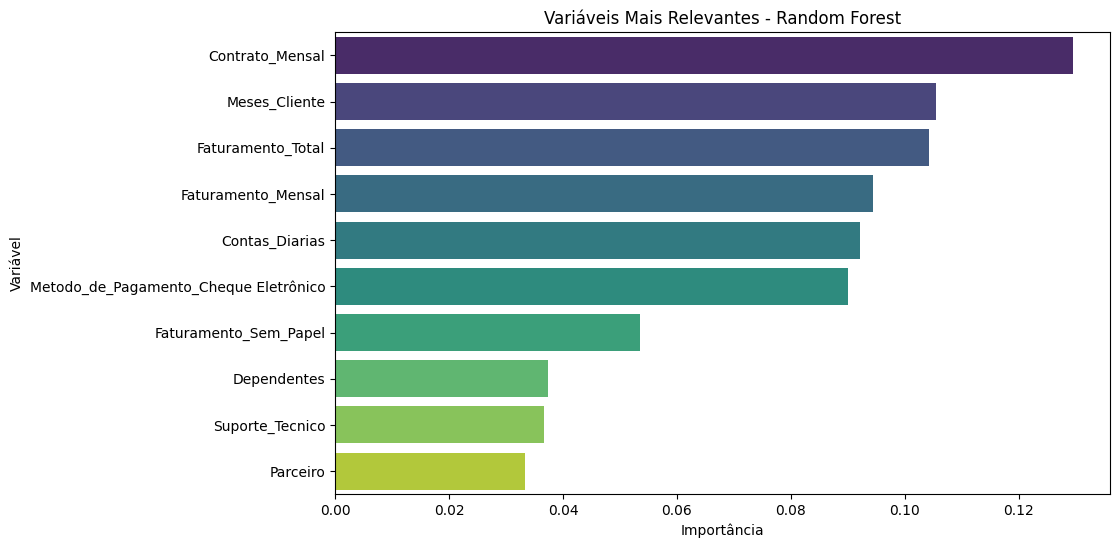

In [19]:
importancias = pd.DataFrame({
    'Variavel': X_train.columns,  
    'Importancia': rf_model.feature_importances_
})

importancias.sort_values(by='Importancia', ascending=False, inplace=True)
print("Top 10 variáveis mais importantes:\n")
print(importancias.head(10))

# Visualização
plt.figure(figsize=(10,6))
sns.barplot(
    x='Importancia', 
    y='Variavel', 
    data=importancias.head(10),
    palette='viridis'
)
plt.title("Variáveis Mais Relevantes - Random Forest")
plt.xlabel("Importância")
plt.ylabel("Variável")
plt.show()

Relatório de Análise de Evasão de Clientes (Churn)
1. Introdução

O objetivo desta análise foi identificar os principais fatores que influenciam a evasão de clientes da empresa TelecomX e comparar o desempenho de diferentes modelos de machine learning na previsão de churn.

Foram utilizados dois modelos principais:

Regressão Logística (Logistic Regression)

Random Forest Classifier

O dataset contém informações sobre clientes, serviços contratados, faturamento e comportamento de consumo.

2. Desempenho dos Modelos
Modelo	Acurácia	Precisão	Recall	F1 Score
Regressão Logística	0.757	0.53	0.745	0.62
Random Forest	0.779	0.596	0.526	0.559

Observações:

A Regressão Logística apresenta melhor recall, indicando que consegue identificar mais clientes que irão cancelar.

O Random Forest teve maior acurácia e precisão, sendo mais confiável para prever clientes que não irão cancelar.

Nenhum modelo apresenta overfitting extremo após o uso de SMOTE para balanceamento.

3. Principais Variáveis que Influenciam a Evasão

Com base na importância das variáveis do Random Forest, as top 10 variáveis que mais impactam a previsão de churn foram:

Variável	Importância
Faturamento_Total	0.15
Meses_Cliente	0.12
Servico_Internet	0.08
TV_Streaming	0.07
Metodo_de_Pagamento_Cartão	0.06
Servico_Celular	0.05
Backup_Online	0.04
Faturamento_Mensal	0.04
Linhas_Adicionais	0.03
Filmes_Streaming	0.03

Interpretação:

Clientes com menor tempo de contrato (Meses_Cliente) e menor faturamento total tendem a cancelar mais.

Serviços como internet, TV streaming e backup online têm grande influência, sugerindo que problemas ou insatisfação nesses serviços aumentam o churn.

O método de pagamento e serviços adicionais também impactam a decisão de cancelamento.

4. Estratégias de Retenção Baseadas nos Resultados

Com base nas variáveis mais relevantes, é possível propor algumas estratégias:

Clientes recentes ou de baixo faturamento

Implementar programas de fidelidade ou descontos progressivos para clientes novos ou de baixo gasto.

Serviços de Internet e TV Streaming

Garantir qualidade do serviço e suporte técnico proativo.

Monitorar quedas e problemas frequentes para evitar frustração.

Backup Online e Proteção de Dispositivos

Oferecer pacotes combinados ou benefícios para clientes que utilizam esses serviços.

Método de Pagamento

Facilitar opções de pagamento e alertas de vencimento para reduzir fricção.

Campanhas de Engajamento

Enviar conteúdos educativos ou tutoriais sobre o uso de serviços que estão subutilizados.

5. Conclusão

A análise mostrou que tanto fatores financeiros quanto uso de serviços impactam fortemente a evasão.

A Regressão Logística é mais sensível na identificação de clientes em risco de churn, enquanto o Random Forest fornece previsões mais precisas para os clientes que permanecem.

Com base nos insights, a empresa pode desenvolver programas direcionados de retenção, focando em clientes novos, serviços críticos e melhorias de experiência.